# COMP551 Assignment 2

## Amir Abushanab - _260624419_

### To ensure the code runs correctly, please use the latest version of Jupyter Notebooks with Python 3.x. The implementation of K-NN is naive so I would also recommend making a copy of the notebook before running it as the classifier takes forever to classify all the test set.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
# First let's begin by importing all the libraries I'll likely be using during the assignment

import numpy as np
from scipy.spatial.distance import euclidean
import pandas as pd
import matplotlib.pyplot as plt
import random
import math

# To make the figures bigger
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 22})

### Q1:

In [3]:
# Import the means and covariance matrix as numpy arrays

ds1_m0 = np.genfromtxt('DS1_m_0.txt', delimiter=',')
ds1_m1 = np.genfromtxt('DS1_m_1.txt', delimiter=',')
ds1_cov = np.genfromtxt('DS1_Cov.txt', delimiter=',')


# Apparently there are nan values in the data so this is just to remove them
ds1_m0 = ds1_m0[~np.isnan(ds1_m0)]
ds1_m1 = ds1_m1[~np.isnan(ds1_m1)]
ds1_cov = ds1_cov[0:20,0:20]

negative_class_data = []
positive_class_data = []

# Generate 2000 data points for each class
for i in range(2001):
    negative_class_data.append(('Negative', np.random.multivariate_normal(ds1_m1, ds1_cov)))
    positive_class_data.append(('Positive', np.random.multivariate_normal(ds1_m0, ds1_cov)))

# Randomly split the data into 30-70 test and train sets as specified in the assigment description
# and save the data as DS1, DS1_test, DS1_train
np.random.shuffle(negative_class_data)
np.random.shuffle(positive_class_data)

d1_data = positive_class_data + negative_class_data
np.random.shuffle(d1_data)
pd.DataFrame(d1_data).to_csv('DS1')

d1_test_data = [x for x in positive_class_data[0:600]] + [y for y in negative_class_data[0:600]]
np.random.shuffle(d1_test_data)
pd.DataFrame(d1_test_data).to_csv('DS1_test')

negative_class_data = negative_class_data[600:2000]
positive_class_data = positive_class_data[600:2000]
d1_train_data = positive_class_data + negative_class_data
np.random.shuffle(d1_train_data)
pd.DataFrame(d1_train_data).to_csv('DS1_train')

### Q2:

In [4]:
class gda_classifier:

    """A GDA (Gaussian Discriminant Analysis) Classifier for use in a binary classification problems"""

    w = None
    w_0 = None

    def fit(self, positive_class_data, negative_class_data):
        
        """Returns the w and w0 coefficient matrices used for classification. Expects a tuple list of each class
        in the format of ("Label", Values) """
        
        # Maximizing w.r.t to phi
        phi = len(positive_class_data) / len(negative_class_data + positive_class_data)

        # Maximizing w.r.t to the means
        estimated_m0 = []
        for i in range(len(positive_class_data[0][1])):
            temp = 0
            for point in positive_class_data:
                temp += point[1][i]
            estimated_m0.append(temp/len(positive_class_data))

        estimated_m1 = []
        for i in range(len(negative_class_data[0][1])):
            temp = 0
            for point in negative_class_data:
                temp += point[1][i]
            estimated_m1.append(temp/len(negative_class_data))

        # Maximizing w.r.t to Sigma (aka covariance) - we begin by finding S1 and S2 then plugging them into the equation
        estimated_s1 = 0.0
        estimated_s2 = 0.0

        # Convert to a numpy matrix for easier calculations. Note that because of the way numpy handles arrays some transposes
        # that may seem out of place are necessary
        estimated_m0_matrix = np.matrix(estimated_m0).transpose()
        for point in positive_class_data:
            temp_matrix = np.matrix(point[1]).transpose()
            temp_result_matrix = (temp_matrix - estimated_m0_matrix) * (temp_matrix - estimated_m0_matrix).transpose()
            estimated_s1 += temp_result_matrix

        estimated_s1 = estimated_s1/len(positive_class_data)

        estimated_m1_matrix = np.matrix(estimated_m1).transpose()
        for point in negative_class_data:
            temp_matrix = np.matrix(point[1]).transpose()
            temp_result_matrix = (temp_matrix - estimated_m1_matrix) * (temp_matrix - estimated_m1_matrix).transpose()
            estimated_s2+= temp_result_matrix

        estimated_s2 = estimated_s2/len(negative_class_data)

        estimated_cov = ((len(positive_class_data)/len(positive_class_data + negative_class_data))*estimated_s1) + ((len(negative_class_data)/len(positive_class_data + negative_class_data))*estimated_s2)

        # Use all the variables found to populate the coefficient matrices w and w_0
        w = (estimated_cov**-1)*(estimated_m0_matrix - estimated_m1_matrix)
        w_0 = -0.5*(estimated_m0_matrix.transpose()*(estimated_cov**-1)*estimated_m0_matrix) + 0.5*(estimated_m1_matrix.transpose()*(estimated_cov**-1)*estimated_m1_matrix) + math.log(phi/(1-phi))
        self.w = w
        self.w_0 = w_0

    def predict(self, point):

        """Returns a prediction between 0 and 1 of whether the given data point belongs to the class. i.e P(C1 | x)
        If P(C1 | x) > 0.5 then that means the data point is C1, otherwise C2. Assumes the classifier is already
        trained. """

        temp_matrix = np.matrix(point).transpose()
        y = self.w.transpose()*temp_matrix + self.w_0
        return 1/(1 + math.exp(-y))


# Evaluating the performance of the classifier on the test set
ds1_classifier = gda_classifier()
ds1_classifier.fit(positive_class_data, negative_class_data)

correct_classifications = 0
incorrect_classifications = 0
true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0

for point in d1_test_data:
    if ds1_classifier.predict(point[1]) > 0.5 :
        if point[0] == "Positive":
            correct_classifications += 1
            true_positives += 1
        else:
            incorrect_classifications += 1
            false_positives += 1
    else:
        if point[0] == "Negative":
            correct_classifications += 1
            true_negatives += 1
        else:
            incorrect_classifications += 1
            false_negatives += 1

ds1_accuracy = correct_classifications / (correct_classifications + incorrect_classifications)
ds1_precision = true_positives/(true_positives + false_positives)
ds1_recall = true_positives/(true_positives + false_negatives)
ds1_f_measure = (2*ds1_precision*ds1_recall) / (ds1_precision + ds1_recall)

# Reporting the coefficient matrix learned by the classifier and the results
print("W = ", ds1_classifier.w)
print("W_0 = ", ds1_classifier.w_0)
print("DS1 classifier accuracy = ", ds1_accuracy)
print("DS1 classifier precision = ", ds1_precision)
print("DS1 classifier recall = ", ds1_recall)
print("DS1 classifier f-measure = ", ds1_f_measure)

W =  [[ 14.90769631]
 [ -9.04574438]
 [ -6.0811307 ]
 [ -3.65246409]
 [-10.00508128]
 [ -4.4250739 ]
 [ 17.83300104]
 [-24.62714191]
 [-30.27271636]
 [  9.42771759]
 [-13.76115051]
 [-12.89189067]
 [ 16.07814277]
 [ 13.42375705]
 [ -5.5327294 ]
 [ 13.21639405]
 [ 30.81407477]
 [ -6.70367716]
 [ -0.89432784]
 [ -5.02612754]]
W_0 =  [[ 28.41888541]]
DS1 classifier accuracy =  0.9633333333333334
DS1 classifier precision =  0.9633333333333334
DS1 classifier recall =  0.9633333333333334
DS1 classifier f-measure =  0.9633333333333334


### Q3:

K = 45 has the best accuracy of 0.5666666666666667
K = 45 has the best precision of 0.5675675675675675
K = 33 has the best recall of 0.5683333333333334
K = 45 has the best f-measure of 0.563758389261745



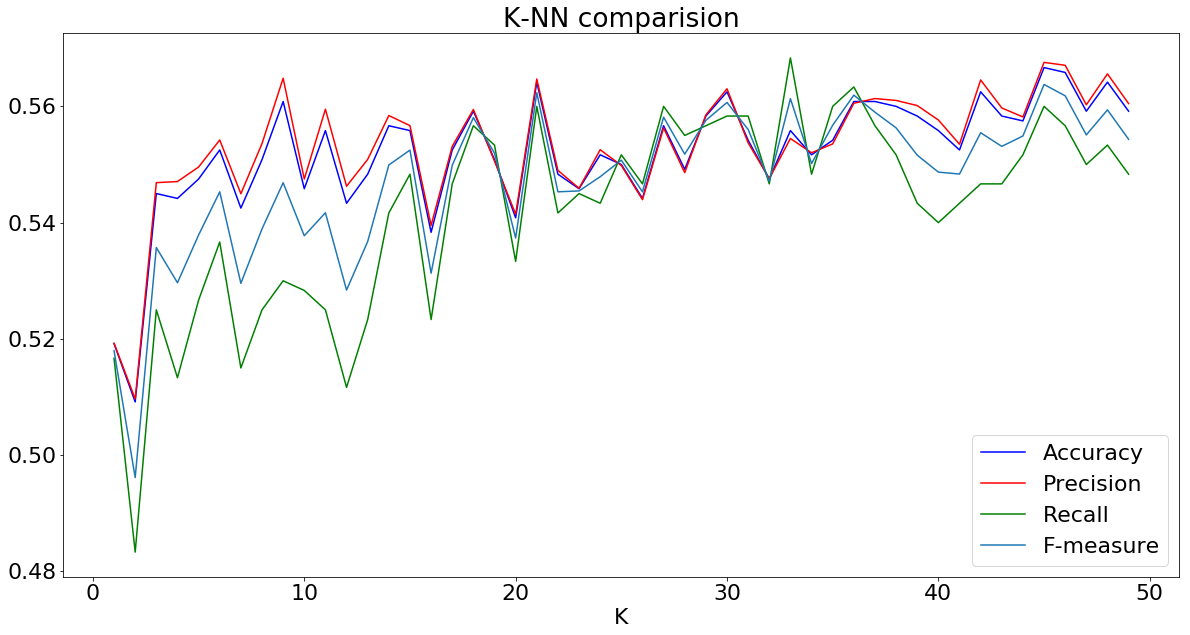

In [5]:
class K_NN_Classifier:

    """A classifier that uses K-NN, for use with 2-class problems. Instantiated by passing it data for class 1
    and class 2, expects a tuple list of each class in the format of ("Label", Values)"""

    def __init__(self, c1, c2):
        self.c1 = c1
        self.c2 = c2

    def predict(self, instance, k):

        """Given a data point classifies it as class 1 or class 2 based on the Euclidean distance from the other
        nearest data points"""

        distances = []
        data = self.c1 + self.c2

        # Calculate the Euclidean distance between the given point and and all the other points. I included the label
        # of each point for efficiency
        for point in data:
            distances.append((abs(euclidean(instance, point[1])), point[0]))

        distances.sort()

        c1_count = 0
        c2_count = 0

        # See what class the closest k points are
        for i in range(k):
            if distances[i][1] == self.c1[0][0]:
                c1_count += 1
            else:
                c2_count += 1

        # If the point is exactly in the middle of c1 and c2 (i.e it lies on the decision boundary), randomly classify
        # it, otherwise return the predicted class
        if c1_count == c2_count:

            if random.random() <= 0.5:

                return self.c1[0][0]

            else:

                return self.c2[0][0]

        elif c1_count > c2_count:

            return self.c1[0][0]

        else:

            return self.c2[0][0]


# Evaluating the performance of the classifier on the test set
ds1_k_nn_classifier = K_NN_Classifier(positive_class_data, negative_class_data)

k_vals = [x for x in range(1, 50)]
ds1_accuracy_vals = []
ds1_precision_vals = []
ds1_recall_vals = []
ds1_f_measure_vals = []

for k in k_vals:

    correct_classifications = 0
    incorrect_classifications = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0

    for point in d1_test_data:

        prediction = ds1_k_nn_classifier.predict(point[1], k)

        if prediction == "Positive":

            if point[0] == "Positive":
                correct_classifications += 1
                true_positives += 1

            else:
                incorrect_classifications += 1
                false_positives += 1

        else:

            if point[0] == "Negative":
                correct_classifications += 1
                true_negatives += 1

            else:
                incorrect_classifications += 1
                false_negatives += 1

    ds1_accuracy_vals.append(correct_classifications / (correct_classifications + incorrect_classifications))
    ds1_precision = true_positives/(true_positives + false_positives)
    ds1_precision_vals.append(ds1_precision)
    ds1_recall = true_positives/(true_positives + false_negatives)
    ds1_recall_vals.append(ds1_recall)
    ds1_f_measure_vals.append((2*ds1_precision*ds1_recall) / (ds1_precision + ds1_recall))

k_acc = ds1_accuracy_vals.index(max(ds1_accuracy_vals))
k_pre = ds1_precision_vals.index(max(ds1_precision_vals))
k_rec = ds1_recall_vals.index(max(ds1_recall_vals))
k_fm = ds1_f_measure_vals.index(max(ds1_f_measure_vals))
#
s = "K = " + str(k_acc + 1) + " has the best accuracy of " + str(ds1_accuracy_vals[k_acc]) + "\n" +\
    "K = " + str(k_pre + 1) + " has the best precision of " + str(ds1_precision_vals[k_pre]) + "\n" +\
    "K = " + str(k_rec + 1) + " has the best recall of " + str(ds1_recall_vals[k_rec]) + "\n" + \
    "K = " + str(k_fm + 1) + " has the best f-measure of " + str(ds1_f_measure_vals[k_fm]) + "\n"

print(s)
plt.title("K-NN comparision")
plt.plot(k_vals, ds1_accuracy_vals, '-b', k_vals, ds1_precision_vals, '-r', k_vals, ds1_recall_vals, '-g', k_vals, ds1_f_measure_vals, '-')
plt.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.xlabel("K")
plt.show()

Overall K-NN preforms worse than LDA, even for the best possible values of K. Note that the best values of K are those around $\sqrt{N}$ where N is the number of datapoints, because K needs to be large enough so that noise in the data is minimized and small enough so that the samples from other classes do not lead to misclassification.

It's also likely that Euclidian distance is a poor metric to use, as the more dimensions you have the "closer" the points will become and the less effective your classifier will be.

### Q4:

In [11]:
# Same as before, import the means and covariance matrix as numpy arrays
ds2_c1_m1 = np.genfromtxt('DS2_c1_m1.txt', delimiter=',')
ds2_c1_m2 = np.genfromtxt('DS2_c1_m2.txt', delimiter=',')
ds2_c1_m3 = np.genfromtxt('DS2_c1_m3.txt', delimiter=',')
ds2_c2_m1 = np.genfromtxt('DS2_c2_m1.txt', delimiter=',')
ds2_c2_m2 = np.genfromtxt('DS2_c2_m2.txt', delimiter=',')
ds2_c2_m3 = np.genfromtxt('DS2_c2_m3.txt', delimiter=',')
ds2_cov1 = np.genfromtxt('DS2_Cov1.txt', delimiter=',')
ds2_cov2 = np.genfromtxt('DS2_Cov2.txt', delimiter=',')
ds2_cov3 = np.genfromtxt('DS2_Cov3.txt', delimiter=',')

# Remove the nan values
ds2_c1_m1 = ds2_c1_m1[~np.isnan(ds2_c1_m1)]
ds2_c1_m2 = ds2_c1_m2[~np.isnan(ds2_c1_m2)]
ds2_c1_m3 = ds2_c1_m3[~np.isnan(ds2_c1_m3)]
ds2_c2_m1 = ds2_c2_m1[~np.isnan(ds2_c2_m1)]
ds2_c2_m2 = ds2_c2_m2[~np.isnan(ds2_c2_m2)]
ds2_c2_m3 = ds2_c2_m3[~np.isnan(ds2_c2_m3)]
ds2_cov1 = ds2_cov1[0:20,0:20]
ds2_cov2 = ds2_cov2[0:20,0:20]
ds2_cov3 = ds2_cov3[0:20,0:20]

# Generate the data for the two classes with the probabilities specified by the assignment
ds2_negative_class_data = []
ds2_positive_class_data = []

for i in range(2000):
    
    prob = random.random()
    
    if prob <= 0.1:
        ds2_negative_class_data.append(('Negative', np.random.multivariate_normal(ds2_c2_m1, ds2_cov1)))
        ds2_positive_class_data.append(('Positive', np.random.multivariate_normal(ds2_c1_m1, ds2_cov1)))
    elif prob <= 0.52:
        ds2_negative_class_data.append(('Negative', np.random.multivariate_normal(ds2_c2_m2, ds2_cov2)))
        ds2_positive_class_data.append(('Positive', np.random.multivariate_normal(ds2_c1_m2, ds2_cov2)))
    else:
        ds2_negative_class_data.append(('Negative', np.random.multivariate_normal(ds2_c2_m3, ds2_cov3)))
        ds2_positive_class_data.append(('Positive', np.random.multivariate_normal(ds2_c1_m3, ds2_cov3)))
    
# Randomly split the data into 30-70 test and train sets as specified in the assigment description
# and save the data as DS2, DS2_test, DS2_train
np.random.shuffle(ds2_negative_class_data)
np.random.shuffle(ds2_positive_class_data)

d2_data = ds2_positive_class_data + ds2_negative_class_data
np.random.shuffle(d2_data)
pd.DataFrame(d2_data).to_csv('DS2')

d2_test_data = [x for x in ds2_positive_class_data[0:600]] + [y for y in ds2_negative_class_data[0:600]]
np.random.shuffle(d2_test_data)
pd.DataFrame(d2_test_data).to_csv('DS2_test')

ds2_negative_class_data = ds2_negative_class_data[600:2000]
ds2_positive_class_data = ds2_positive_class_data[600:2000]
d2_train_data = ds2_positive_class_data + ds2_negative_class_data
np.random.shuffle(d2_train_data)
pd.DataFrame(d2_train_data).to_csv('DS2_train')

### Q5:

In [12]:
# Evaluating the performance of the ds2 classifier on the test set. Note that I could have made this into a function,
# but copy pasting was just easier ;) 

ds2_classifier = gda_classifier()
ds2_classifier.fit(ds2_positive_class_data, ds2_negative_class_data)

correct_classifications = 0
incorrect_classifications = 0
true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0

for point in d2_test_data:
    if ds2_classifier.predict(point[1]) > 0.5 :
        if point[0] == "Positive":
            correct_classifications += 1
            true_positives += 1
        else:
            incorrect_classifications += 1
            false_positives += 1
    else:
        if point[0] == "Negative":
            correct_classifications += 1
            true_negatives += 1
        else:
            incorrect_classifications += 1
            false_negatives += 1

ds2_accuracy = correct_classifications / (correct_classifications + incorrect_classifications)
ds2_precision = true_positives/(true_positives + false_positives)
ds2_recall = true_positives/(true_positives + false_negatives)
ds2_f_measure = (2*ds2_precision*ds2_recall) / (ds2_precision + ds2_recall)

print("W = ", ds2_classifier.w)
print("W_0 = ", ds2_classifier.w_0)
print("DS2 classifier accuracy = ", ds2_accuracy)
print("DS2 classifier precision = ", ds2_precision)
print("DS2 classifier recall = ", ds2_recall)
print("DS2 classifier f-measure = ", ds2_f_measure)

W =  [[-0.01059624]
 [-0.00897818]
 [-0.05599648]
 [-0.01065705]
 [-0.00202497]
 [-0.03813692]
 [ 0.03592923]
 [-0.0017725 ]
 [-0.02183308]
 [-0.04591945]
 [ 0.00486843]
 [ 0.01285129]
 [ 0.04168069]
 [ 0.02380758]
 [-0.03058976]
 [-0.05009061]
 [-0.00630761]
 [ 0.02088705]
 [ 0.02084615]
 [ 0.0609494 ]]
W_0 =  [[ 0.07001212]]
DS2 classifier accuracy =  0.5383333333333333
DS2 classifier precision =  0.5357142857142857
DS2 classifier recall =  0.575
DS2 classifier f-measure =  0.5546623794212218


K = 48 has the best accuracy of 0.5383333333333333
K = 48 has the best precision of 0.532394366197183
K = 48 has the best recall of 0.63
K = 48 has the best f-measure of 0.5770992366412213



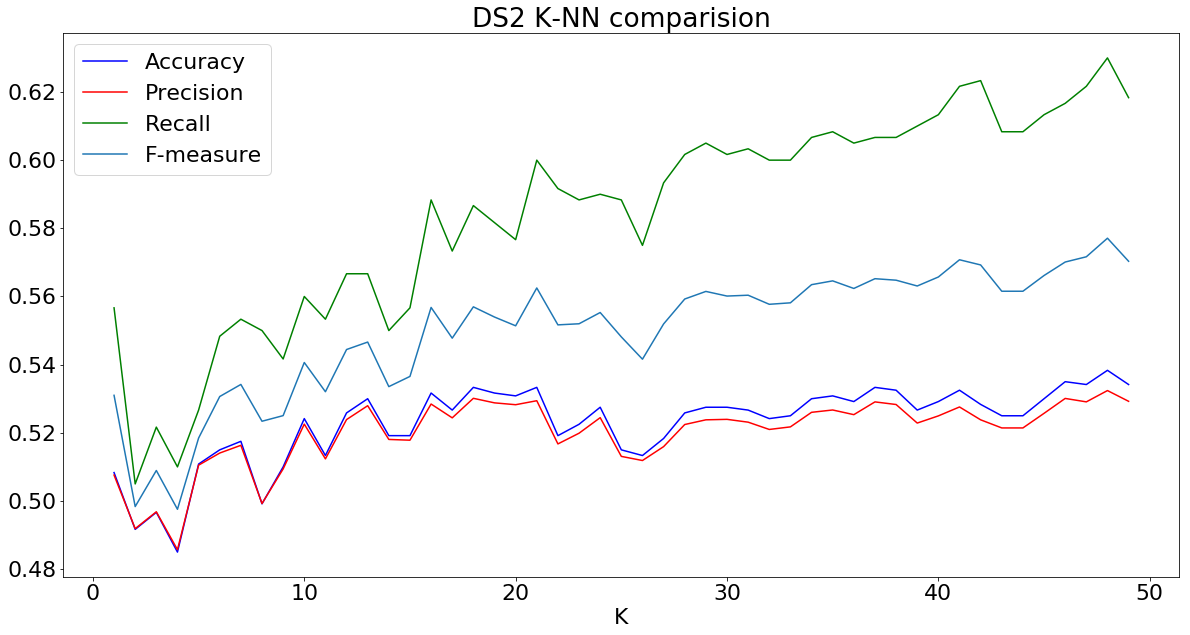

In [13]:
# Evaluating the performance of the k-nn classifier on the ds2 test set. Once again, I could have created a function
# and copy pasting is poor software engineering practice, but I'm probably only using this once anyway so sue me

ds2_k_nn_classifier = K_NN_Classifier(positive_class_data, negative_class_data)

ds2_accuracy_vals = []
ds2_precision_vals = []
ds2_recall_vals = []
ds2_f_measure_vals = []

for k in k_vals:

    correct_classifications = 0
    incorrect_classifications = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0

    for point in d2_test_data:

        prediction = ds2_k_nn_classifier.predict(point[1], k)

        if prediction == "Positive":

            if point[0] == "Positive":
                correct_classifications += 1
                true_positives += 1

            else:
                incorrect_classifications += 1
                false_positives += 1

        else:

            if point[0] == "Negative":
                correct_classifications += 1
                true_negatives += 1

            else:
                incorrect_classifications += 1
                false_negatives += 1

    ds2_accuracy_vals.append(correct_classifications / (correct_classifications + incorrect_classifications))
    ds2_precision = true_positives/(true_positives + false_positives)
    ds2_precision_vals.append(ds2_precision)
    ds2_recall = true_positives/(true_positives + false_negatives)
    ds2_recall_vals.append(ds2_recall)
    ds2_f_measure_vals.append((2*ds2_precision*ds2_recall) / (ds2_precision + ds2_recall))

k_acc = ds2_accuracy_vals.index(max(ds2_accuracy_vals))
k_pre = ds2_precision_vals.index(max(ds2_precision_vals))
k_rec = ds2_recall_vals.index(max(ds2_recall_vals))
k_fm = ds2_f_measure_vals.index(max(ds2_f_measure_vals))

s = "K = " + str(k_acc + 1) + " has the best accuracy of " + str(ds2_accuracy_vals[k_acc]) + "\n" +\
    "K = " + str(k_pre + 1) + " has the best precision of " + str(ds2_precision_vals[k_pre]) + "\n" +\
    "K = " + str(k_rec + 1) + " has the best recall of " + str(ds2_recall_vals[k_rec]) + "\n" + \
    "K = " + str(k_fm + 1) + " has the best f-measure of " + str(ds2_f_measure_vals[k_fm]) + "\n"

print(s)
plt.title("DS2 K-NN comparision")
plt.plot(k_vals, ds2_accuracy_vals, '-b', k_vals, ds2_precision_vals, '-r', k_vals, ds2_recall_vals, '-g', k_vals, ds2_f_measure_vals, '-')
plt.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.xlabel("K")
plt.show()

The LDA Classifier only classifies correctly ~50% of the time, meaning that it is essentially a coin flip. The K-NN classifier preforms a bit better as we increase the value of k but only up to a certain point.

### Q6:

The preformance of LDA (aka GDA) has decreased considerably for DS2 and is not nearly as accurate as when the classes were generated simply from one gaussian. On the other hand, the preformance of K-NN has actually improved a bit and it preforms better than LDA on DS2. This is likely because K-NN is a general algorithm that assumes no prior knowledge of the data, making it better suited for classifying items that do not all fit a particular pattern.